In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from n2v.utils.n2v_utils import manipulate_val_data
from csbdeep.utils import _raise, axes_check_and_normalize, axes_dict, load_json, save_json
from n2v.utils.n2v_utils import pm_identity, pm_normal_additive, pm_normal_fitted, pm_uniform_withCP
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from n2v.internals.N2V_DataWrapper import N2V_DataWrapper
from matplotlib import pyplot as plt
from keras import optimizers
import urllib
import os
import zipfile
import tensorflow as tf

/home/random/.conda/envs/n2v/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/random/.conda/envs/n2v/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/random/.conda/envs/n2v/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/random/.conda/envs/n2v/lib/python3.7/site-packages/tensorf

In [2]:
#freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
import keras.backend as K
K.set_learning_phase(1)
        

In [3]:
# create a folder for our data.
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath="data/SEM.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/pXgfbobntrw06lC/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

datagen = N2V_DataGenerator()

imgs = datagen.load_imgs_from_directory(directory = "data/")

# We will use the first image to extract training patches and store them in 'X'
X = datagen.generate_patches_from_list(imgs[:1], shape=(96,96))

# We will use the second image to extract validation patches.
X_val = datagen.generate_patches_from_list(imgs[1:], shape=(96,96))

# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches would also allow us to split them into a training and validation set 
# per image. This might be an interesting alternative to the split we performed above.

Generated patches: (3536, 96, 96, 1)
Generated patches: (544, 96, 96, 1)


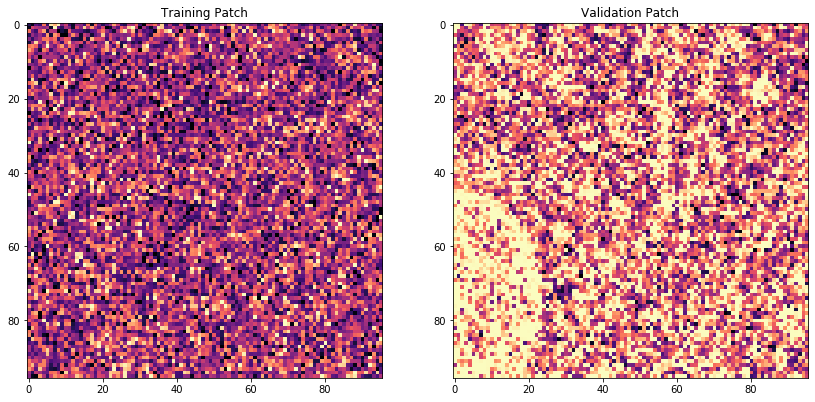

In [4]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

In [5]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=5,train_epochs=5, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=1.6, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['39137.86'],
 'stds': ['18713.787'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 5,
 'train_steps_per_epoch': 5,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.6,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'probabilistic': False}

In [6]:
# a name used to identify the model
model_name = 'n2v_2D_2'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

Instructions for updating:
Colocations handled automatically by placer.


/media/data/Development/python/n2v/n2v/models/n2v_standard.py:409: UserWarning: output path for model already exists, files may be overwritten: /media/data/Development/imagej/project/CSBDeep/CSBDeep-N2V/src/main/python/models/n2v_2D_2
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [7]:
#optimizer = optimizers.SGD(lr=0.01)
#isinstance(optimizer, optimizers.Optimizer) or print(ValueError())

tfoptimizer = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-7)
model.prepare_for_training(optimizer = optimizers.TFOptimizer(tfoptimizer))
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [8]:
loss = tf.get_default_graph().get_tensor_by_name("loss/mul:0")
train_op = tfoptimizer.minimize(loss, name='train')
init_op = tf.global_variables_initializer()
tf.train.Saver().as_saver_def()

filename_tensor_name: "save/Const:0"
save_tensor_name: "save/control_dependency:0"
restore_op_name: "save/restore_all"
max_to_keep: 5
keep_checkpoint_every_n_hours: 10000.0
version: V2

In [9]:
#with open('../resources/graph.pb', 'wb') as f:
#    f.write(tf.get_default_graph().as_graph_def().SerializeToString())

In [10]:
# a name used to identify the model
model_name = 'n2v_2D'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

/media/data/Development/python/n2v/n2v/models/n2v_standard.py:409: UserWarning: output path for model already exists, files may be overwritten: /media/data/Development/imagej/project/CSBDeep/CSBDeep-N2V/src/main/python/models/n2v_2D
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [11]:
n_train = len(X)
axes = axes_check_and_normalize('S'+config.axes,X.ndim)
ax = axes_dict(axes)
div_by = 2**config.unet_n_depth
axes_relevant = ''.join(a for a in 'XYZT' if a in axes)
train_num_pix = 1
for a in axes_relevant:
    n = X.shape[ax[a]]
    train_num_pix *= X.shape[ax[a]]
    if n % div_by != 0:
        raise ValueError(
            "training images must be evenly divisible by %d along axes %s"
            " (axis %s has incompatible size %d)" % (div_by,axes_relevant,a,n)
        )

epochs = 3
steps_per_epoch = 10

model.prepare_for_training()

manipulator = eval('pm_{0}({1})'.format(config.n2v_manipulator, str(config.n2v_neighborhood_radius)))

means = np.array([float(mean) for mean in model.config.means], ndmin=len(X.shape), dtype=np.float32)
stds = np.array([float(std) for std in config.stds], ndmin=len(X.shape), dtype=np.float32)

X = model.__normalize__(X, means, stds)

# Here we prepare the Noise2Void data. Our input is the noisy data X and as target we take X concatenated with
# a masking channel. The N2V_DataWrapper will take care of the pixel masking and manipulating.
training_data = N2V_DataWrapper(X, np.concatenate((X, np.zeros(X.shape, dtype=X.dtype)), axis=axes.index('C')),
                                            config.train_batch_size, config.n2v_perc_pix,
                                            config.n2v_patch_shape, manipulator)

65 blind-spots will be generated per training patch of size (64, 64).


[None, 3.0294313, 1.4113694, 3.0294313]
[None, 2.0761373, 1.1440797, 2.076137]
[None, 5.979171, 1.925118, 5.9791703]
[None, 2.3288124, 1.2409701, 2.3288124]
[None, 0.99472904, 0.83210796, 0.99472904]
[None, 0.74110293, 0.71375614, 0.74110293]
[None, 0.6711102, 0.6676653, 0.6711103]
[None, 0.66849804, 0.66253716, 0.66849804]
[None, 0.6417647, 0.64914364, 0.64176476]


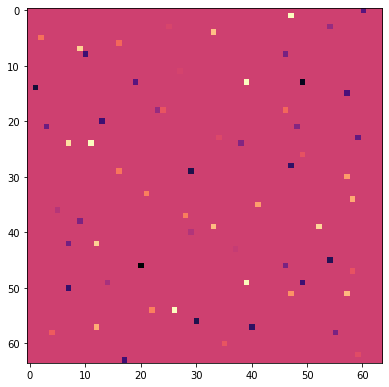

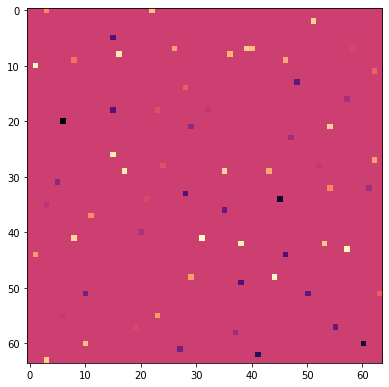

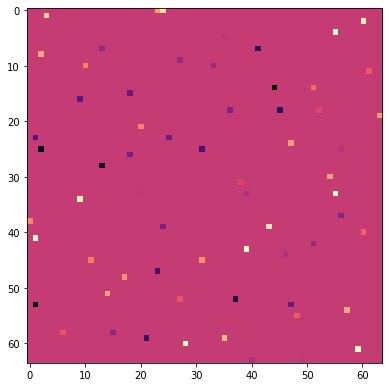

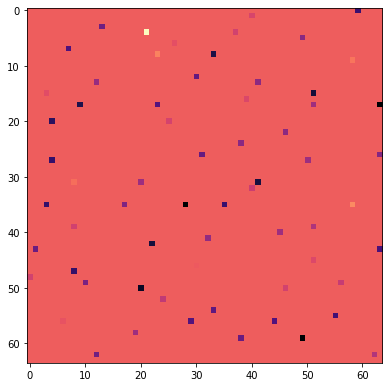

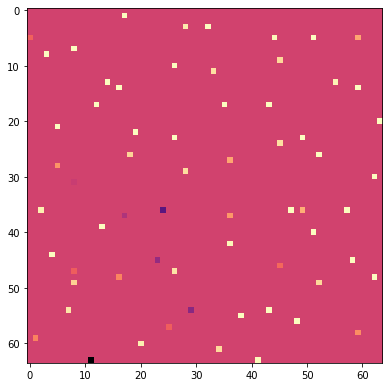

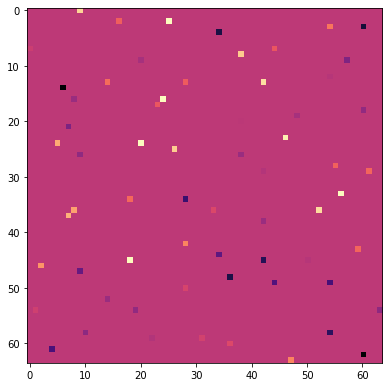

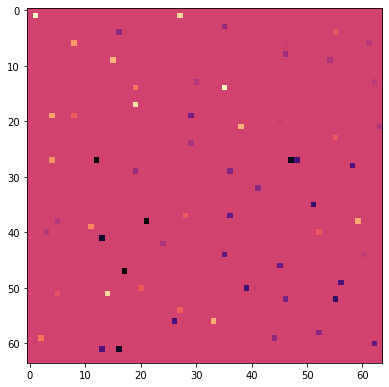

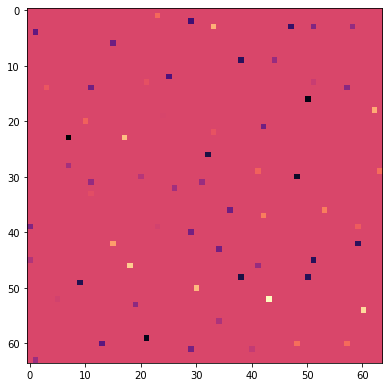

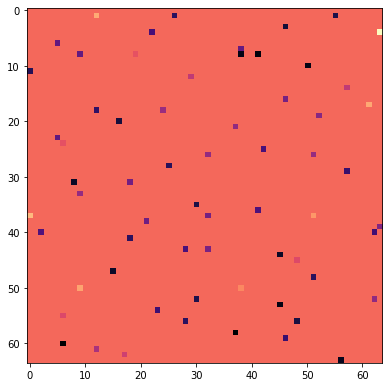

In [13]:
sess = tf.Session()
sess.run(init_op)

index = 0
for j in range(3):
    for i in range(3):
        xy = training_data.__getitem__(i)
        #print(xy[0].shape)
        
#         count = 0
#         for k in range(64):
#             slice = xy[1][0,0,:,1].astype(int)
#             count += np.bincount(slice)[1]
            
#         print(count)
        
#         plt.figure(figsize=(14,7))
#         plt.subplot(1,2,1)
#         plt.imshow(xy[1][0,...,1], cmap='magma')
#         plt.title('X')
#         plt.subplot(1,2,2)
#         plt.imshow(xy[1][1,...,1], cmap='magma')
#         plt.title('Y')
        
        index += 1
        res = sess.run(["train","loss/mul:0", "metrics/n2v_abs/Mean:0","metrics/n2v_mse/Mean:0"], feed_dict={"input:0": xy[0], "activation_11_target:0": xy[1], "activation_11_sample_weights:0": np.ones(64)})
        print(res)
    training_data.on_epoch_end()
